# Kernels are EVERYWHERE

In a previous class, we saw how the **kernel trick** allows SVMs to solve **non-linear** classification problems efficiently by implicitly mapping the data into a higher-dimensional space without ever computing the mapping explicitly.

But the idea of kernels is **not limited to SVMs**.

In fact, **any algorithm that involves dot products and can be expressed in its dual form**—that is, in terms of **similarities between observations rather than features**—can potentially be **"kernelized"**.

Today, we will see how this idea extends to two other methods:

- **Kernel PCA** – a non-linear version of Principal Component Analysis.

- **Kernel Ridge Regression** – a kernelized approach to L2 regularized regression.

At the end of this class, as an exercise, you will be asked to implement a **kernelized version of the Perceptron** in `PyTorch`, and explore how different kernel functions affect the model’s decision boundary.

## 1. Kernel PCA

### 1.1. Theory

If you remember, Principal Component Analysis (PCA) aims to find uncorrelated "directions" (principal components), represented as columns of the matrix $U$, that maximize the variance of the data. This corresponds to the eigenvalue decomposition of the empirical covariance matrix:

$$
\mathcal{C} = \frac{1}{N} X^T X,
$$
where $X$ is the **centered** input data.

We solve:

$$
\mathcal{C} U = U \Lambda \quad \Rightarrow \quad \frac{1}{N} X^T X U = U \Lambda
$$

Multiply both sides from the left by \(X\):

$$
X (X^T X) U = X U (N \Lambda)
$$

Using associativity:

$$
(X X^T)(X U) = (X U) (N \Lambda)
$$

Define:

- The **Kernel matrix** $K = X X^T$
- The projected components in data space: $V = X U$

Then:

$$
K V = V (N \Lambda)
$$

This shows that **diagonalizing the covariance matrix in (any) feature space** (columns of $U$) is equivalent to **diagonalizing the kernel matrix** $K$, with eigenvectors $V = X U$.

In other words, we have turned the problem of computing the principal components in feature space into the problem of diagonalizing the **kernel matrix**, which encodes similarities between observed data points. 

Ok, so we learned $V$, now what? Now we can **project** any new data $X'$ into the principal component space

$$Z = K' \tilde{V}$$

where $\tilde{V}$ is normalized version of the eigenvectors of $K$ and $K' = K(X, X')$, that is, the kernel values between the new points and the points used to learn $V$ (the training set!).

Now, replace  X in all the above formulas with $\tilde{X}=\phi(X)$, a (possibly high- or infinite-dimensional) feature map. In that case, the kernel entries are $K = \tilde{X} \tilde{X}^T$. 

Crucially, all this allows us to maximize the variance in a **potentially high- or infinite- dimensional space** without explicitly constructing that space — this is again the core of the **kernel trick**.


<div class="alert alert-info"> 

**Summary**

- Kernel PCA is just PCA applied in a high-dimensional feature space, typically involving a nonlinear mapping of the original data.
- The **kernel trick** lets us compute everything using kernel values $K(x, x')$, avoiding explicit feature mapping.
- This allows us to extract **principal components** that capture curved or complex structure in the data.

</div>

### 1.2. Implementation

You can find its implementation in `scikit-learn` in  the module `decomposition` under the name `KernelPCA`. 

Please, take a few moments to inspect the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA), particularly its different parameters.

### 1.3. Code demonstration

For this demonstration, let us use again the data from the XOR problem. We used this data in the previous lesson.

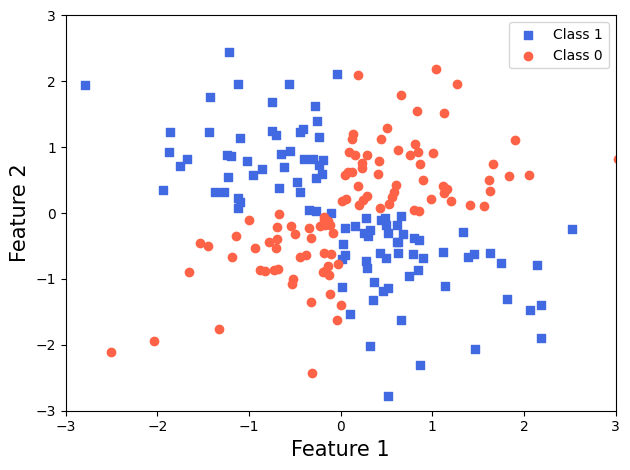

In [2]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, 0)

plt.scatter(X_xor[y_xor == 1, 0],X_xor[y_xor == 1, 1], c='royalblue', marker='s', label='Class 1')
plt.scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1], c='tomato', marker='o',label='Class 0')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.xlabel('Feature 1', size=15)
plt.ylabel('Feature 2', size=15)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Now, we will use PCA **with** and **without** a kernel to explore the effect of applying a kernel transformation.

Specifically, we will compare standard PCA with Kernel PCA using a Radial Basis Function (RBF) kernel.

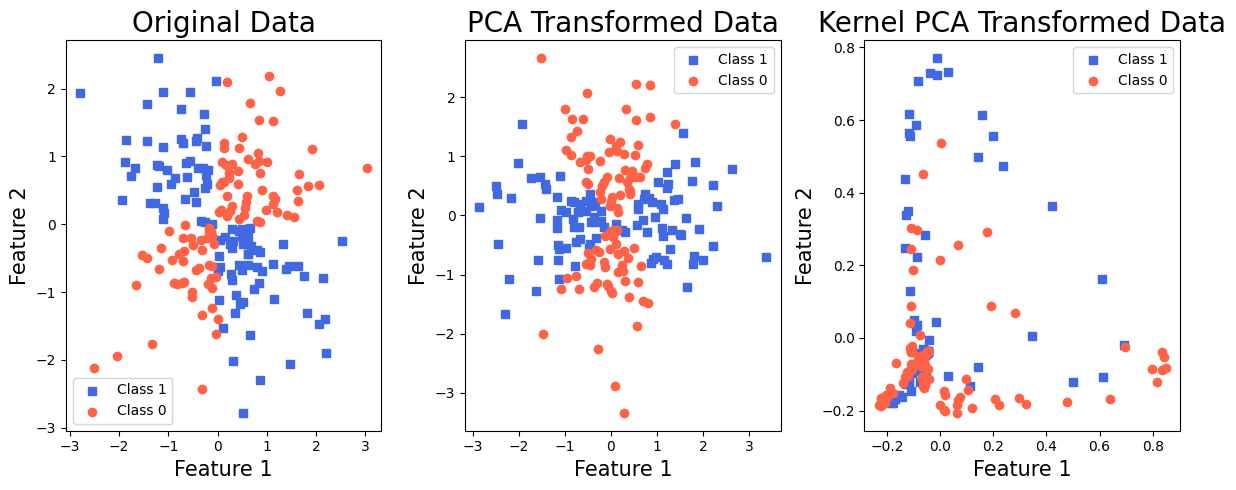

In [3]:
from sklearn.decomposition import KernelPCA, PCA

pca = PCA(n_components=2)
kernel_pca = KernelPCA(
    n_components=2, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
)

X_pca = pca.fit(X_xor).transform(X_xor)
X_kernel_pca = kernel_pca.fit(X_xor).transform(X_xor)

# Plot the original data and the transformed data
plt.figure(figsize=(12, 5))
 
plt.subplot(1, 3, 1)
plt.scatter(X_xor[y_xor == 1, 0],X_xor[y_xor == 1, 1], c='royalblue', marker='s', label='Class 1')
plt.scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1], c='tomato', marker='o',label='Class 0')
plt.title('Original Data', size=20)
plt.xlabel('Feature 1', size=15)
plt.ylabel('Feature 2', size=15)
plt.legend(loc='best')

plt.subplot(1, 3, 2)
plt.scatter(X_pca[y_xor == 1, 0],X_pca[y_xor == 1, 1], c='royalblue', marker='s', label='Class 1')
plt.scatter(X_pca[y_xor == 0, 0], X_pca[y_xor == 0, 1], c='tomato', marker='o',label='Class 0')
plt.title('PCA Transformed Data', size=20)
plt.xlabel('Feature 1', size=15)
plt.ylabel('Feature 2', size=15)
plt.legend(loc='best')
 

plt.subplot(1, 3, 3)
plt.scatter(X_kernel_pca[y_xor == 1, 0],X_kernel_pca[y_xor == 1, 1], c='royalblue', marker='s', label='Class 1')
plt.scatter(X_kernel_pca[y_xor == 0, 0], X_kernel_pca[y_xor == 0, 1], c='tomato', marker='o',label='Class 0')
plt.title('Kernel PCA Transformed Data', size=20)
plt.xlabel('Feature 1', size=15)
plt.ylabel('Feature 2', size=15)
plt.legend(loc='best')

plt.tight_layout()
plt.show()

We can see that **standard PCA** does not significantly alter the distribution of our classes — they remain clearly non-separable in the projected space.

However, **Kernel PCA** appears to transform the space in a way that hints at **improved separability** between the classes.

 Let’s test this! For that, we will now evaluate and compare their performance by training a SVM with a linear kernel on the untransformed, PCA- and Kernel PCA-transformed data. We will also visualize the resulting decision boundaries.

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

clf_orig = make_pipeline(SVC(kernel="linear"))
clf_pca = make_pipeline(PCA(), SVC(kernel="linear"))
clf_kpca = make_pipeline(KernelPCA(kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1), SVC(kernel="linear"))

X_train, X_test, y_train, y_test = train_test_split(X_xor, y_xor, random_state=0)

acc_orig = clf_orig.fit(X_train, y_train).score(X_test, y_test)
acc_pca = clf_pca.fit(X_train, y_train).score(X_test, y_test)
acc_kpca =  clf_kpca.fit(X_train, y_train).score(X_test, y_test)

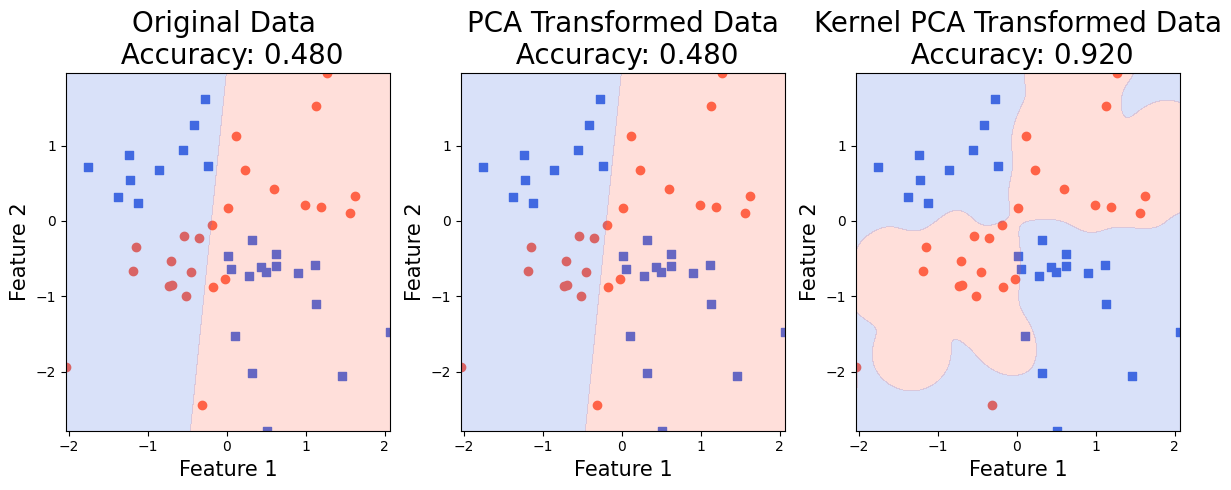

In [5]:
# Create meshgrid for plotting
x_min, x_max = X_test[:, 0].min(), X_test[:, 0].max()
y_min, y_max = X_test[:, 1].min(), X_test[:, 1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

# Plot the original data and the transformed data
plt.figure(figsize=(12, 5))

Z = clf_orig.decision_function(grid).reshape(xx.shape) 
plt.subplot(1, 3, 1)
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], c='tomato', marker='o',label='Class 0')
plt.scatter(X_test[y_test == 1, 0],X_test[y_test == 1, 1], c='royalblue', marker='s', label='Class 1')
plt.contourf(xx, yy, Z, levels=[Z .min(), 0, Z .max()], colors=['tomato','royalblue'], alpha=0.2)
plt.title(f'Original Data \n Accuracy: {acc_orig:.3f}', size=20)
plt.xlabel('Feature 1', size=15)
plt.ylabel('Feature 2', size=15)

Z = clf_pca.decision_function(grid).reshape(xx.shape) 

plt.subplot(1, 3, 2)
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], c='tomato', marker='o',label='Class 0')
plt.scatter(X_test[y_test == 1, 0],X_test[y_test == 1, 1], c='royalblue', marker='s', label='Class 1')
plt.contourf(xx, yy, Z, levels=[Z .min(), 0, Z .max()], colors=['tomato','royalblue'], alpha=0.2)
plt.title(f'PCA Transformed Data\n Accuracy: {acc_pca:.3f}', size=20)
plt.xlabel('Feature 1', size=15)
plt.ylabel('Feature 2', size=15)


Z = clf_kpca.decision_function(grid).reshape(xx.shape) 
plt.subplot(1, 3, 3)
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], c='tomato', marker='o',label='Class 0')
plt.scatter(X_test[y_test == 1, 0],X_test[y_test == 1, 1], c='royalblue', marker='s', label='Class 1')
plt.contourf(xx, yy, Z, levels=[Z .min(), 0, Z .max()], colors=['tomato','royalblue'], alpha=0.2)
plt.title(f'Kernel PCA Transformed Data\n Accuracy: {acc_kpca:.3f}', size=20)
plt.xlabel('Feature 1', size=15)
plt.ylabel('Feature 2', size=15)


plt.tight_layout()
plt.show()

The results speak for themselves:

- Raw data (no PCA): ~48% accuracy  
- Standard PCA: ~48% accuracy  
- Kernel PCA (with RBF): 92% accuracy

Quite impressive, right!?

By transforming the feature space, **Kernel PCA** uncovers structure that allows a linear classifier like SVM to perform remarkably well on a problem that was otherwise non-separable.


## 2.1. Kernel Ridge Regression

**Kernel Ridge Regression (KRR)** is a powerful example of how a **linear model** can be transformed into a **non-linear one** by leveraging the **kernel trick**.

### 2.1. Theory


The standard **ridge regression** cost function, assuming the data has been **centered** (so the intercept $b = 0$)), is:

$$
\min_{w} \; J = (y - X\vec{w})^T(y - X\vec{w}) + \lambda \|\vec{w}\|^2
$$

The solution that minimizes this is:

$$
\vec{w} = (X^T X + \lambda \mathcal{I}_M)^{-1} X^T y
$$

Using the matrix identity:

$$
(A + B C B^T)^{-1} B = B (C^{-1} + B^T A^{-1} B)^{-1}
$$

we can equivalently rewrite this as:

$$
\vec{w} = X^T (\lambda \mathcal{I}_N + X X^T)^{-1} y
$$

Now, as you can see, the **kernel matrix** $K = X X^T$ appears here again.

Let us define:

$$
\alpha = (\lambda \mathcal{I}_N + K)^{-1} y
$$

Then:

$$
\vec{w} = X^T \alpha
$$

So the weights $w$ are a **linear combination of the training samples**:

$$
\vec{w} = \sum_{i=1}^N \alpha_i \vec{x}_i
$$

Any prediction on a new input $x$ becomes:

$$
\hat{y} = \vec{x}\cdot \vec{w} = \sum_{i=1}^N \alpha_i (\vec{x}\cdot \vec{x}_i) = \sum_{i=1}^N \alpha_i K(x, x_i)
$$

That is, **each prediction is a weighted sum of the similarities** (via the kernel) between the new input and each training point.

This is where we apply the **kernel trick**: replace the inner product $x^T x_i$ in the original feature space with:

$$
K(x, x_i) = \phi(x)^T \phi(x_i)
$$

**Kernel Ridge Regression** therefore expresses the solution as a linear combination of training points in a (possibly infinite-dimensional) feature space. The kernel trick allows us to compute everything using kernel evaluations, without explicitly computing $\phi(x)$.


### 2.2. Implementation

You can find its implementation in `scikit-learn` in  the module `kernel_ridge` under the name `KernelRidge`. 

Please, take a few moments to inspect the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html), particularly its different parameters.

### 2.3. Code demostration 

For this demostration we will generate some data that has a sinusoidal relation with the outcome variable:

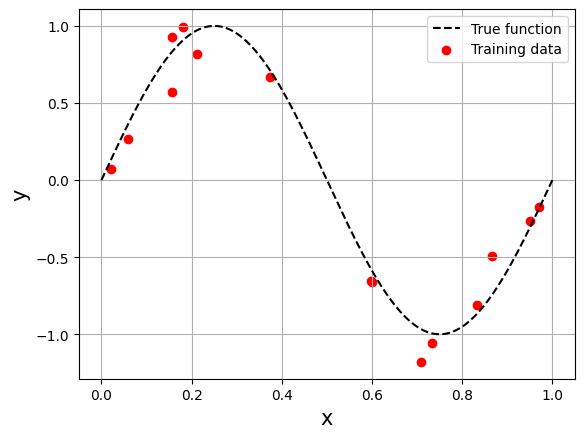

In [6]:
# Ground truth function
def f(x): return np.sin(2 * np.pi * x)

# Generate data following this 
np.random.seed(42)
X_train = np.sort(np.random.rand(15, 1), axis=0)
y_train = f(X_train).ravel() + 0.1 * np.random.randn(15)

# Test data
X_test = np.linspace(0, 1, 200).reshape(-1, 1)
y_true = f(X_test)

plt.plot(X_test, y_true, 'k--', label="True function")
plt.scatter(X_train, y_train, c='r', label="Training data")
plt.xlabel("x", size=15)
plt.ylabel("y", size=15)
plt.legend()
plt.grid(True)

Knowing the ground truth, let's first fit a **Ridge Regression** model where we transform our input feature using a **polynomial expansion**. 

We will try this for different degrees of expansion to see how well the model can capture the non-linear relationship.

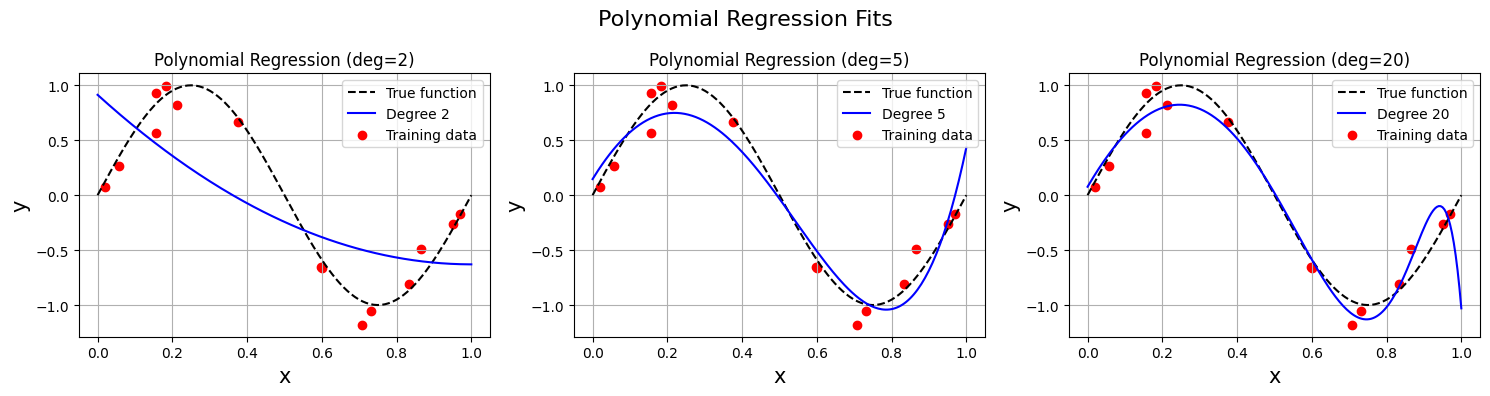

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

degrees = [2, 5, 20]

plt.figure(figsize=(15, 4))
for i, deg in enumerate(degrees, 1):
    model = make_pipeline(PolynomialFeatures(deg), Ridge(alpha=1e-3))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    plt.subplot(1, 3, i)
    plt.plot(X_test, y_true, 'k--', label="True function")
    plt.plot(X_test, y_pred, 'b-', label=f"Degree {deg}")
    plt.scatter(X_train, y_train, c='r', label="Training data")
    plt.title(f"Polynomial Regression (deg={deg})")
    plt.xlabel("x", size=15)
    plt.ylabel("y", size=15)
    plt.legend()
    plt.grid(True)

plt.suptitle("Polynomial Regression Fits", fontsize=16)
plt.tight_layout()
plt.show()


And now, we will try to do the same using a **KRR** model, hoping that the use of a **kernel function** will help us capture the non-linear relationship more effectively — without explicitly transforming the input features.

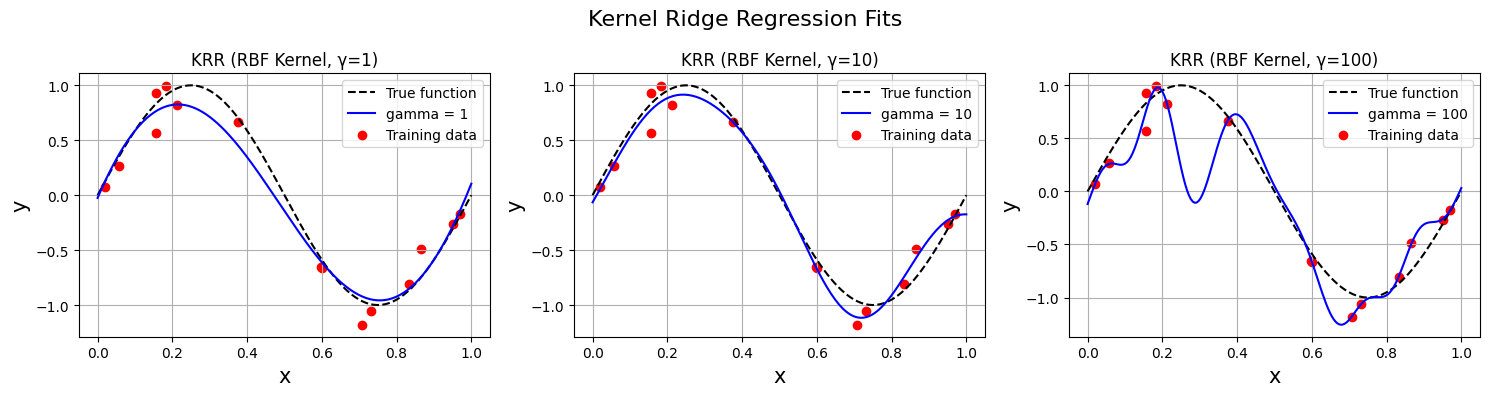

In [15]:
from sklearn.kernel_ridge import KernelRidge

gammas = [1, 10, 100]

plt.figure(figsize=(15, 4))
for i, gamma in enumerate(gammas, 1):
    krr = KernelRidge(alpha=1e-3, kernel='rbf', gamma=gamma)
    krr.fit(X_train, y_train)
    y_pred = krr.predict(X_test)

    plt.subplot(1, 3, i)
    plt.plot(X_test, y_true, 'k--', label="True function")
    plt.plot(X_test, y_pred, 'b-', label=f"gamma = {gamma}")
    plt.scatter(X_train, y_train, c='r', label="Training data")
    plt.title(f"KRR (RBF Kernel, γ={gamma})")
    plt.xlabel("x", size=15)
    plt.ylabel("y", size=15)
    plt.legend()
    plt.grid(True)

plt.suptitle("Kernel Ridge Regression Fits", fontsize=16)
plt.tight_layout()
plt.show()


So what are the advantages and disadvantages of using KRR vs. transformaing your data first using, for example, a polynomial expansion?

- When manually transforming the data using a polynomial expansion, you must choose the transformation degree — too low may underfit, too high may overfit.

- KRR with an RBF kernel handles non-linearity automatically using similarity-based modeling, reducing the need for manual feature engineering.

- Kernel methods operate in implicit high-dimensional spaces without explicitly computing the transformation, so they scale with the **number of samples**, not the number of transformed **features**. This might be a disadvantage for large datasets.


<div class="alert alert-warning">

**QUESTION:** Wait? but didn't we say in previous class about SVM that only a subset of points contributes because only a few $\alpha$'s 
    are nonzero? Why do you think then we should care about having large datasets here?
    
</div>

## 3. Summary

- **Kernel methods** extend linear models to non-linear problems by implicitly mapping the data into high-dimensional spaces.

- **Kernel PCA** leverages the kernel trick for **dimensionality reduction**, often revealing structure that standard PCA cannot capture.

- **Kernel Ridge Regression (KRR)** combines ridge regularization with kernel-based modeling to solve non-linear regression problems without manual feature engineering.

- While powerful, kernel methods can become computationally expensive for large datasets, as they scale with the number of samples rather than the number of features.


## 4. 📝 Exercise: Kernel Perceptron (RBF Kernel)

Your goal in this exercise is to extend the **Perceptron algorithm** that we saw a few lessons ago to classify nonlinearly separable data using the **kernel trick**. Like we Ridge Regression, this will demonstrate, first-hand, how adding kernels to existing methods can help you have more complex decision boundaries. 

This is called the **kernel perceptron** and, using the dual form, generates predictions according for a given $x$ to the following:

$$\hat{y} = \mbox{sign}\sum_i \alpha_i y_i K(x_i, x)$$
where here we are summing over the examples in the training set, $alpha_i$ counts the number of times each training sample is missclasified, and $y_i \in \{−1, +1\}$ and $K(x_i, x)$ is the usual **kernel function**.

Its pseudo learning algorithm is as follows: 

>    - Initialize $\alpha_i$ = 0 for all $i$ in the training set
>    - for some fixed number of epochs:
        - for each training sample $x_j$, $y_j$
          - Compute prediction: $\hat{y}_j = \mbox{sign}\sum_i \alpha_i y_i K(x_i, x_j)$
          - If $\hat{y}_j \neq y_j$ then $\alpha_j \leftarrow \alpha_j + 1$
> - Store: $\alpha_i$, $x_i$, $y_i$ for which $\alpha_i > 0$ (support vectors)

The last step of just storing those examples with $\alpha>0$ is for efficiency, given that examples with $alpha=0$ will not contribute to the predictions.

For more information, you can visit: [Wikipedia – Kernel Perceptron](https://en.wikipedia.org/wiki/Kernel_perceptron)

---

In this exercise, you will not implement the algorithm from scratch, but instead fill in the missing parts of a pre-defined structure.

Let’s start by creating the dataset for this exercise:

In [8]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch

X, y = make_moons(n_samples=200, noise=0.2, random_state=42)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

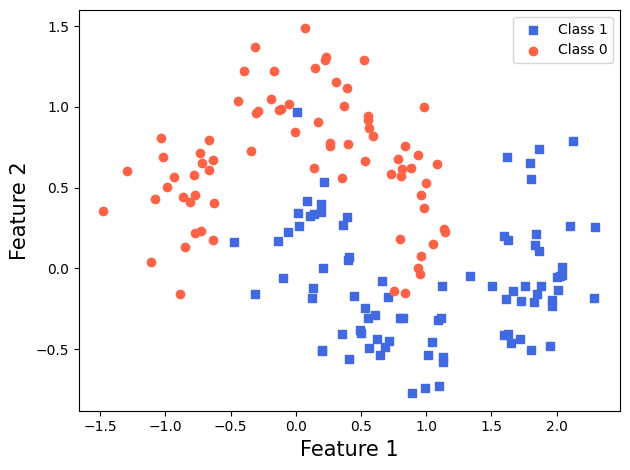

In [9]:
import matplotlib.pylab as plt

plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='royalblue', marker='s', label='Class 1')
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c='tomato', marker='o',label='Class 0')
plt.xlabel('Feature 1', size=15)
plt.ylabel('Feature 2', size=15)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Below is the backbone code for the Kernel Perceptron.  

**Please complete the sections marked with `# TODO`.**

For this exercise, we will use the *Radial Basis Function (RBF) kernel, defined as:

$$
K(x_1, x_2) = \exp(-\gamma \|x_1 - x_2\|^2)
$$

where $\gamma$ is a hyperparameter that controls the width of the kernel.


In [ ]:
class KernelPerceptron(object):
    def __init__(self, gamma=5.0, max_epochs=100):
        self.gamma = gamma
        self.max_epochs = max_epochs
        
    def rbf_kernel(self, x_1, x_2):
        # TODO: Complete the radial basis function (RBF) kernel between two examples
        return

    def fit(self, X, y):
        labels = y.clone().detach()
        labels[labels ==0] = -1 # convert to {-1, +1}
        alphas = # TODO: Initialize a vector of zeros of equal size of the training set
        
        for epoch in range(self.max_epochs):
            # TODO: Complete main loop over training set examples and alpha update
            
        # Keep only support vectors (examples with alpha > 0)
        self.alphas_ = alphas[alphas > 0]
        self.support_vectors_ = X[alphas > 0]
        self.support_labels_ = labels[alphas > 0]
        
        return self
    
    def predict(self, X):
        preds = torch.zeros(len(X), dtype=torch.int)
        weighted_sum = 0
        for i in range(len(X)):
            weighted_sum = 0
            for alpha, xp, label in zip(self.alphas_, self.support_vectors_, self.support_labels_):
                K = self.rbf_kernel(X[i], xp)
                weighted_sum += alpha * label * K
            pred = torch.sign(weighted_sum)
            # Convert to 0, 1
            preds[i] = (pred > 0).int()
        
        return preds

Once you have completed all the sections marked with `# TODO`, train the model by running the following code:

In [ ]:
kp = KernelPerceptron(gamma=1.0, max_epochs=10)
kp.fit(X_train, y_train)

And if everything went well, the following code should produce a figure showing the distribution of the test set observations, the decision boundary learned by the Kernel Perceptron, and the model’s accuracy (it will take a bit).

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Performance of the model
acc = accuracy_score(y_test, kp.predict(X_test))

# The decision boundary
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1


xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

Z = kp.predict(grid_tensor)
Z = Z.reshape(xx.shape)

# Plot everything
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm_r, alpha=0.6)

plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], c='royalblue', marker='s', label='Class 1')
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], c='tomato', marker='o',label='Class 0')
plt.xlabel('Feature 1', size=15)
plt.ylabel('Feature 2', size=15)
plt.legend(loc='best')
plt.title(f"Kernel Perceptron (RBF), Accuracy: {acc:.3f}", size=20)
plt.tight_layout()
plt.show()

Now, as a final task, compare the performance and decision boundary of your Kernel Perceptron with that of the standard Perceptron.

For simplicity, use the implementation provided by `scikit-learn`: `Perceptron`, available in the `linear_model` module.

In [ ]:
# YOUR CODE